In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
%pylab inline
figsize(12, 9)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='normal')
plt.rc('font', size=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import sys
import matplotlib as mpl
from sklearn.datasets import load_svmlight_file
from subprocess import call
import gc
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier

Populating the interactive namespace from numpy and matplotlib


# Критерий |TPR - FPR| Юдин Никита, 517 группа

Как известно, при пострении решающих деревьев для решения задачи классификации используют обычно либо критерий Джини (gini), либо энтропийный (entropy). А выбор подходящего разбиения в решающем дереве происходит в результате максимизации следующей функции:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R)$ &mdash; критерий.
Для критерия Джини $H(R) = 1 - p_{0}^{2} - p_{1}^{2}$, где $p_{0}, p_{1}$ &mdash; доля объектов 0 и 1 класса соответственно. Для энтропийного критерия $H(R) = -p_{0}\log_{2}p_{0} - p_{1}\log_{2}p_{1}$. Рассмотрим бинарную задачу классификации. Рассмотрим и сравним с упомянутыми выше критерий TPR-FPR, который заключается в том, что в каждом узле решается бинарная задача классификации с классификатором в виде пороговой функции, которая настраивается максимизацией AUC ROC на объектах, расположенных в рассматриваемом узле. Как было установлено на семинаре, максимизация AUC ROC эквивалентна максимизации следующей разности: $|TPR - FPR|$. В данной работе объекты, отправляющиеся в правый узел по критерию |TPR - FPR|, трактуются как объекты положительного класса. TPR &mdash; чувствительность, FPR &mdash; доля ложноположительных объектов.

В ходе выполнения работы я установил, что безболезненно включить собственную функцию критерия разбиения в узле в библиотеке scikit-learn не получится, поэтому эксперименты были проведены с использованием модифицированного кода из лабораторной работы за третий курс. Ниже приведена функция, находящая оптимальное разбиение в зависимости от выбранного критерия:

In [2]:
def find_best_split(feature_vector, target_vector, criterion='gini'):
    if len(feature_vector) != len(target_vector):
        raise ValueError('arguments are not aligned')
    if not criterion in ['gini', 'tpr_minus_fpr', 'entropy']:
        raise ValueError('unknown criterion')
    thresholds = np.unique(feature_vector)[1:]
    if thresholds.size == 0:
        return -np.inf, -np.inf, -np.inf, -np.inf
    mask_map = feature_vector[np.newaxis, :] < thresholds[:, np.newaxis]
    left_node_size = mask_map.sum(axis=1).astype(np.float)
    right_node_size = target_vector.size - left_node_size
    labels = np.unique(target_vector)
    positive_class_pos = target_vector.copy()
    positive_class_pos[target_vector == labels[0]] = 0
    positive_class_pos[target_vector == labels[1]] = 1
    positive_class_pos = positive_class_pos.astype(np.int)
    positive_class_pos[positive_class_pos != 1] = 0
    positive_left_count = (positive_class_pos[np.newaxis, :] * mask_map).sum(axis=1)
    positive_right_count = (positive_class_pos[np.newaxis, :] * ~mask_map).sum(axis=1)
    if criterion == 'gini':
        ginis = 2.0 / float(target_vector.size) *\
                (positive_left_count * (positive_left_count / left_node_size - 1.0) +\
                positive_right_count * (positive_right_count / right_node_size - 1.0))
        index = np.argmax(ginis)
        return thresholds, ginis, thresholds[index], ginis[index]
    elif criterion == 'tpr_minus_fpr':
        tpr_minus_fpr = np.abs(positive_right_count / (positive_right_count + positive_left_count) -\
                        (right_node_size - positive_right_count) / (target_vector.size - positive_right_count -\
                        positive_left_count))
        index = np.argmax(tpr_minus_fpr)
        return thresholds, tpr_minus_fpr, thresholds[index], tpr_minus_fpr[index]
    elif criterion == 'entropy':
        entropy = (positive_right_count / target_vector.size) * np.log2(positive_right_count / right_node_size +\
                                                                        1e-6) +\
                  ((right_node_size - positive_right_count) / target_vector.size) *\
                  np.log2((right_node_size - positive_right_count) / right_node_size + 1e-6) +\
                  (positive_left_count / target_vector.size) * np.log2(positive_left_count / left_node_size +\
                                                                       1e-6) +\
                  ((left_node_size - positive_left_count) / target_vector.size) *\
                  np.log2((left_node_size - positive_left_count) / left_node_size + 1e-6)
        index = np.argmax(entropy)
        return thresholds, entropy, thresholds[index], entropy[index]
    else:
        return None, None, None, None

Ниже представлены выборы порогов в корне решающего дерева для различных признаков из преобразованной выборки [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling). Для трёх признаков все критерии показали одинаковый результат, однако наблюдается различие по признакам STG, PEG.

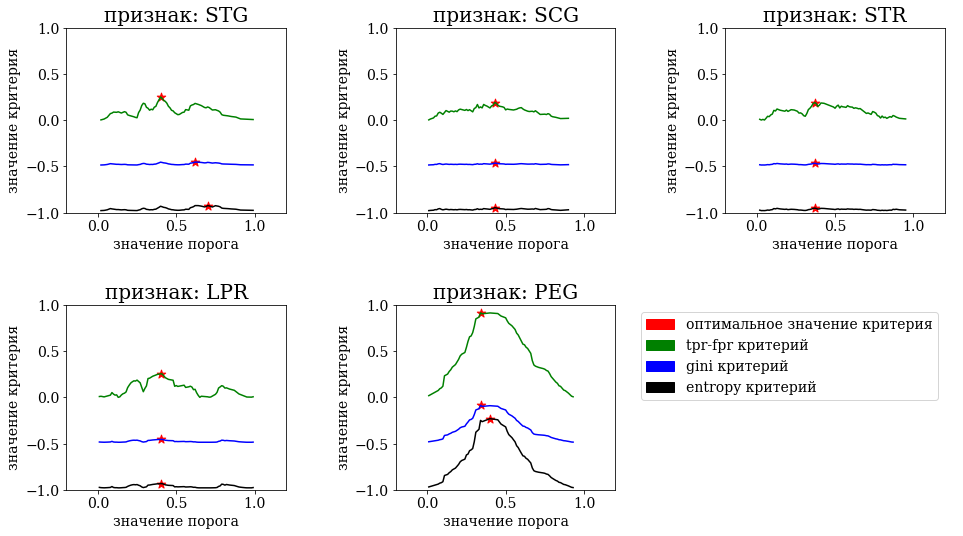

In [3]:
students = pd.read_csv('students.csv')
students_features_num = len(students.columns) - 1
students_target = np.array(students[students.columns[students_features_num]])
students_design = np.array(students[students.columns[:students_features_num]])
fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(2, 3)
gs.update(left=0.57, right=1.79, wspace=0.5, hspace=0.5)
red_patch = mpatches.Patch(color='red', label='оптимальное значение критерия')
blue_patch = mpatches.Patch(color='blue', label='gini критерий')
green_patch = mpatches.Patch(color='green', label='tpr-fpr критерий')
black_patch = mpatches.Patch(color='black', label='entropy критерий')
ax = plt.subplot(gs[5])
ax.legend(handles=[red_patch, green_patch, blue_patch, black_patch])
ax.axis('off')
splits_features = []
for i in range(students_features_num):
    split_info = find_best_split(students_design[:, i], students_target)
    splits_features.append(split_info)
    ax = plt.subplot(gs[i])
    ax.plot(split_info[0], split_info[1], color='blue')
    ax.scatter(split_info[2], split_info[3], s=80, marker='*', color='red')
    split_info = find_best_split(students_design[:, i], students_target, criterion='tpr_minus_fpr')
    splits_features.append(split_info)
    ax.plot(split_info[0], split_info[1], color='green')
    ax.scatter(split_info[2], split_info[3], s=80, marker='*', color='red')
    split_info = find_best_split(students_design[:, i], students_target, criterion='entropy')
    splits_features.append(split_info)
    ax.plot(split_info[0], split_info[1], color='black')
    ax.scatter(split_info[2], split_info[3], s=80, marker='*', color='red')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-1.0, 1.0])
    plt.title('признак: ' + students.columns[i], fontsize=20)
    plt.xlabel('значение порога', fontsize=14)
    plt.ylabel('значение критерия', fontsize=14)
plt.show()

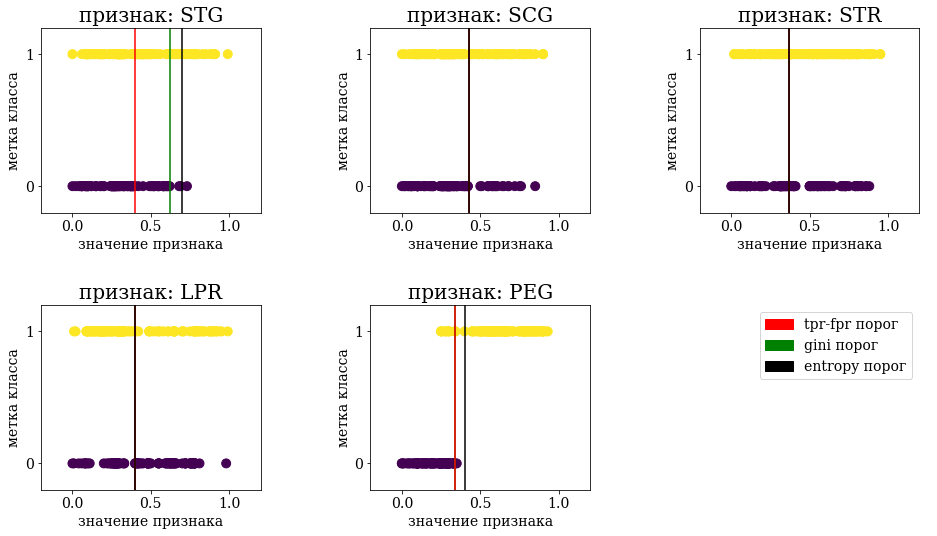

In [4]:
fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(2, 3)
gs.update(left=0.57, right=1.79, wspace=0.5, hspace=0.5)
green_patch = mpatches.Patch(color='green', label='gini порог')
red_patch = mpatches.Patch(color='red', label='tpr-fpr порог')
black_patch = mpatches.Patch(color='black', label='entropy порог')
ax = plt.subplot(gs[5])
ax.legend(handles=[red_patch, green_patch, black_patch])
ax.axis('off')
for i in range(students_features_num):
    ax = plt.subplot(gs[i])
    ax.scatter(students_design[:, i], students_target, c=students_target, s=80)
    ax.plot(np.zeros(8) + splits_features[3 * i][2], np.linspace(-0.2, 1.2, 8), color='green')
    ax.plot(np.zeros(8) + splits_features[3 * i + 1][2], np.linspace(-0.2, 1.2, 8), color='red')
    ax.plot(np.zeros(8) + splits_features[3 * i + 2][2], np.linspace(-0.2, 1.2, 8), color='black')
    plt.title('признак: ' + students.columns[i], fontsize=20)
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.yticks([0, 1])
    plt.xlabel('значение признака', fontsize=14)
    plt.ylabel('метка класса', fontsize=14)
plt.show()

Загрузим выборки для дальнейших экспериментов:

In [5]:
%%time
call("wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/breast-cancer".split())
call("wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon".split())
call("wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon.t".split())
call("wget -t inf https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt".split())
call("wget -t inf https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv".split())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


Создадим таблицу для записи результатов экспериментов:

In [6]:
results = pd.DataFrame(index=pd.Index(['mushroom', 'pima', 'breast cancer', 'madelon', 'banknote'], name='Task'),
                       columns=pd.MultiIndex.from_tuples([('gini', 'accuracy'), ('gini', 'AUC ROC'),
                                                        ('TPR-FPR', 'accuracy'), ('TPR-FPR', 'AUC ROC'),
                                                        ('entropy', 'accuracy'), ('entropy', 'AUC ROC'),
                                                        ('description', 'size'), ('description', 'features num'),
                                                        ('description', 'positive class ratio')]))

Загрузим выборку **mushroom**:

In [7]:
filename_list = ['breast-cancer', 'madelon', 'madelon.t', 'data_banknote_authentication.txt', 'pima-indians-diabetes.data.csv']
ohe = OneHotEncoder(sparse=False)
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                        names=np.hstack((np.array(['mushroom type']), np.arange(1, 23).astype(np.string_))))
results.loc['mushroom', ('description', 'size')] = mushrooms.shape[0]
results.loc['mushroom', ('description', 'features num')] = mushrooms.shape[1] - 1
mushrooms_target = np.array(mushrooms[mushrooms.columns[0]])
mushrooms_design = np.array(mushrooms[mushrooms.columns[1:]])
le = LabelEncoder()
mushrooms_target = le.fit_transform(mushrooms_target)
results.loc['mushroom', ('description', 'positive class ratio')] = mushrooms_target.mean()
for i in range(mushrooms_design.shape[1]):
    mushrooms_design[:, i] = le.fit_transform(mushrooms_design[:, i])
ohe_mushrooms_design = ohe.fit_transform(mushrooms_design)
mushrooms_X_train, mushrooms_X_test, mushrooms_y_train, mushrooms_y_test = train_test_split(mushrooms_design,
                                                                                            mushrooms_target,
                                                                                            test_size=0.5,
                                                                                            random_state=42)

Ниже представлен код, реализующий решающие деревья, совместимые с интерфейсом библиотеки scikit-learn. Осторожно, работает медленнее, чем реализация решающих деревьев в scikit-learn. Дерево строится до конца: до того момента, пока в узле не останутся представители одного класса, в реализацию встроена возможность работы с категориальными признаками, в конструктор класса необходимо передавать маску категориальных признаков.

In [8]:
class DecisionTree(BaseEstimator):
    def __init__(self, types, criterion='gini'):
        self._tree = []
        self.types = types
        self.criterion = criterion

    def fit(self, X, y):
        def orderEncoder(cat_feature, target):
            cats, counts = np.unique(cat_feature, return_counts=True)
            labels = np.unique(target)
            tmp_target = target.copy()
            tmp_target[target == labels[0]] = 0
            tmp_target[target == labels[1]] = 1
            tmp_target = tmp_target.astype(np.int)
            positive_counts = ((cat_feature[np.newaxis, :] == cats[:, np.newaxis]) &\
                               tmp_target[np.newaxis, :]).sum(axis=1)
            frequentcies = positive_counts / counts
            pairs = list(zip(frequentcies, cats))
            pairs.sort(key=lambda x: x[0])
            enc_feature = np.zeros(cat_feature.size)
            for i in range(len(pairs)):
                enc_feature[cat_feature == pairs[i][1]] = i
            return enc_feature, pairs


        def fit_node(subX, suby, node):
            labels = np.unique(suby)
            if labels.size == 1:
                node.append(labels[0])
                return
            splits_info = []
            for i in range(self.types.size):
                if self.types[i]:
                    enc_feature, enc_list = orderEncoder(subX[:, i], suby)
                    _, _, threshold, gini = find_best_split(enc_feature, suby, self.criterion)
                    splits_info.append((gini, threshold, enc_list, i))
                else:
                    _, _, threshold, gini = find_best_split(subX[:, i], suby, self.criterion)
                    splits_info.append((gini, threshold, i))
            splits_info.sort(key=lambda x: x[0])
            subX_left, subX_right, suby_left, suby_right = [], [], [], []
            if len(splits_info[-1]) == 4:
                right_split_set = []
                for i, pair in zip(range(len(splits_info[-1][2])), splits_info[-1][2]):
                    if i < splits_info[-1][1]:
                        continue
                    right_split_set.append(pair[1])
                right_split_set = set(right_split_set)
                node.append(splits_info[-1][3])
                node.append(right_split_set)
                node.append([])
                node.append([])
                for x, y in zip(subX, suby):
                    if x[splits_info[-1][3]] in right_split_set:
                        subX_right.append(x)
                        suby_right.append(y)
                    else:
                        subX_left.append(x)
                        suby_left.append(y)
                subX_right = np.array(subX_right)
                subX_left = np.array(subX_left)
                suby_right = np.array(suby_right)
                suby_left = np.array(suby_left)
            else:
                node.append(splits_info[-1][2])
                node.append(splits_info[-1][1])
                node.append([])
                node.append([])
                division_mask = subX[:, splits_info[-1][2]] < splits_info[-1][1]
                subX_left = subX[division_mask, :]
                suby_left = suby[division_mask]
                division_mask = ~division_mask
                subX_right = subX[division_mask, :]
                suby_right = suby[division_mask]
            fit_node(subX_left, suby_left, node[2])
            fit_node(subX_right, suby_right, node[3])

            
        self._tree = []
        fit_node(X, y, self._tree)

        
    def predict(self, X):
        def predict_node(x, node):
            if isinstance(node[1], set):
                if x[node[0]] in node[1]:
                    if len(node[3]) > 1:
                        return predict_node(x, node[3])
                    else:
                        return node[3]
                else:
                    if len(node[2]) > 1:
                        return predict_node(x, node[2])
                    else:
                        return node[2]
            else:
                if x[node[0]] < node[1]:
                    if len(node[2]) > 1:
                        return predict_node(x, node[2])
                    else:
                        return node[2]
                else:
                    if len(node[3]) > 1:
                        return predict_node(x, node[3])
                    else:
                        return node[3]
            
            
        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)


    def get_tree(self):
        return self._tree.copy()

В экспериментах выборки делились поровну на обучающую и на тестовую, если заранее не были разделены. Результат классификации случайного леса из одного дерева на выборке **mushroom** с критерием Джини:

In [9]:
clf = DecisionTree(np.ones(mushrooms_design.shape[1]))
clf.fit(mushrooms_X_train, mushrooms_y_train)
results.loc['mushroom', ('gini', 'accuracy')] = accuracy_score(y_pred=clf.predict(mushrooms_X_test), y_true=mushrooms_y_test)
results.loc['mushroom', ('gini', 'AUC ROC')] = roc_auc_score(y_true=mushrooms_y_test, y_score=clf.predict(mushrooms_X_test))
print('accuracy on test is:', results.loc['mushroom', ('gini', 'accuracy')])
print('AUC ROC on test is:', results.loc['mushroom', ('gini', 'AUC ROC')])
print('tree topology:')
clf.get_tree()

accuracy on test is: 1.0
AUC ROC on test is: 1.0
tree topology:


[4,
 {1, 2, 4, 6, 7, 8},
 [19,
  {5},
  [14,
   {8},
   [1,
    {1},
    [0,
     {1},
     [14, {4}, [21, {2}, [0], [19, {7}, [0], [1]]], [11, {1}, [0], [1]]],
     [1]],
    [1]],
   [1]],
  [1]],
 [1]]

Результат классификации случайного леса из одного дерева на выборке **mushroom** с критерием TPR-FPR, дерево оказалось менее глубоким:

In [10]:
clf = DecisionTree(np.ones(mushrooms_design.shape[1]), criterion='tpr_minus_fpr')
clf.fit(mushrooms_X_train, mushrooms_y_train)
results.loc['mushroom', ('TPR-FPR', 'accuracy')] = accuracy_score(y_pred=clf.predict(mushrooms_X_test), y_true=mushrooms_y_test)
results.loc['mushroom', ('TPR-FPR', 'AUC ROC')] = roc_auc_score(y_true=mushrooms_y_test, y_score=clf.predict(mushrooms_X_test))
print('accuracy on test is:', results.loc['mushroom', ('TPR-FPR', 'accuracy')])
print('AUC ROC on test is:', results.loc['mushroom', ('TPR-FPR', 'AUC ROC')])
print('tree topology:')
clf.get_tree()

accuracy on test is: 1.0
AUC ROC on test is: 1.0
tree topology:


[4,
 {1, 2, 4, 6, 7, 8},
 [19, {5, 7}, [0], [20, {4}, [21, {2}, [0], [1]], [21, {0, 1, 3}, [0], [1]]]],
 [1]]

Результат классификации случайного леса из одного дерева на выборке **mushroom** с энтропийным критерием:

In [11]:
clf = DecisionTree(np.ones(mushrooms_design.shape[1]), criterion='entropy')
clf.fit(mushrooms_X_train, mushrooms_y_train)
results.loc['mushroom', ('entropy', 'accuracy')] = accuracy_score(y_pred=clf.predict(mushrooms_X_test), y_true=mushrooms_y_test)
results.loc['mushroom', ('entropy', 'AUC ROC')] = roc_auc_score(y_true=mushrooms_y_test, y_score=clf.predict(mushrooms_X_test))
print('accuracy on test is:', results.loc['mushroom', ('entropy', 'accuracy')])
print('AUC ROC on test is:', results.loc['mushroom', ('entropy', 'AUC ROC')])
print('tree topology:')
clf.get_tree()

accuracy on test is: 1.0
AUC ROC on test is: 1.0
tree topology:


[4,
 {1, 2, 4, 6, 7, 8},
 [19, {5}, [7, {1}, [0], [12, {3}, [20, {1}, [0], [1]], [1]]], [1]],
 [1]]

Загружаем выборку **pima**:

In [12]:
df = pd.read_csv(filename_list[-1], names=np.hstack((np.arange(1, 9).astype(np.string_), np.array(['y']))))

Размер выборки:

In [13]:
results.loc['pima', ('description', 'size')] = df.shape[0]
results.loc['pima', ('description', 'features num')] = df.shape[1] - 1
df.shape

(768, 9)

Доля положительных объектов в выборке:

In [14]:
results.loc['pima', ('description', 'positive class ratio')] = df.y.mean()
results.loc['pima', ('description', 'positive class ratio')]

0.3489583333333333

Разделяем выборку на обучающую и тестовую:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :8].as_matrix(), df.iloc[:, 8].as_matrix(),
                                                    test_size=0.5,
                                                    random_state=42)

Результат классификации случайного леса из 20 деревьев на выборке **pima** с критерием Джини:

In [16]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='gini'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['pima', ('gini', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['pima', ('gini', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['pima', ('gini', 'accuracy')])
print('AUC ROC on test is:', results.loc['pima', ('gini', 'AUC ROC')])

accuracy on test is: 0.7864583333333334
AUC ROC on test is: 0.7597213809812235


Результат классификации случайного леса из 20 деревьев на выборке **pima** с критерием TPR-FPR:

In [17]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='tpr_minus_fpr'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['pima', ('TPR-FPR', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['pima', ('TPR-FPR', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['pima', ('TPR-FPR', 'accuracy')])
print('AUC ROC on test is:', results.loc['pima', ('TPR-FPR', 'AUC ROC')])

accuracy on test is: 0.75
AUC ROC on test is: 0.7077528770442156


Результат классификации случайного леса из 20 деревьев на выборке **pima** с энтропийным критерием:

In [18]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='entropy'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['pima', ('entropy', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['pima', ('entropy', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['pima', ('entropy', 'accuracy')])
print('AUC ROC on test is:', results.loc['pima', ('entropy', 'AUC ROC')])

accuracy on test is: 0.7838541666666666
AUC ROC on test is: 0.7633858267716536


Загружаем выборку **breast cancer**:

In [19]:
X, y = load_svmlight_file(filename_list[0])
X = X.toarray()

Размер выборки: 

In [20]:
results.loc['breast cancer', ('description', 'size')] = X.shape[0]
results.loc['breast cancer', ('description', 'features num')] = X.shape[1]
X.shape

(683, 10)

Доля положительных объектов в выборке:

In [21]:
y[y == 2] = 0
y[y == 4] = 1
results.loc['breast cancer', ('description', 'positive class ratio')] = y.mean()
results.loc['breast cancer', ('description', 'positive class ratio')]

0.34992679355783307

Разбиение выборки на обучающую и тестовую:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

Результат классификации случайного леса из 20 деревьев на выборке **breast cancer** с критерием Джини:

In [23]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='gini'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['breast cancer', ('gini', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['breast cancer', ('gini', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['breast cancer', ('gini', 'accuracy')])
print('AUC ROC on test is:', results.loc['breast cancer', ('gini', 'AUC ROC')])

accuracy on test is: 0.9444444444444444
AUC ROC on test is: 0.9303418171056524


Результат классификации случайного леса из 20 деревьев на выборке **breast cancer** с критерием TPR-FPR:

In [24]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='tpr_minus_fpr'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['breast cancer', ('TPR-FPR', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['breast cancer', ('TPR-FPR', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['breast cancer', ('TPR-FPR', 'accuracy')])
print('AUC ROC on test is:', results.loc['breast cancer', ('TPR-FPR', 'AUC ROC')])

accuracy on test is: 0.9502923976608187
AUC ROC on test is: 0.9349289730689553


Результат классификации случайного леса из 20 деревьев на выборке **breast cancer** с энтропийным критерием:

In [25]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='entropy'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['breast cancer', ('entropy', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['breast cancer', ('entropy', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['breast cancer', ('entropy', 'accuracy')])
print('AUC ROC on test is:', results.loc['breast cancer', ('entropy', 'AUC ROC')])

accuracy on test is: 0.9532163742690059
AUC ROC on test is: 0.9406999112163361


Загружаем выборку **madelon**:

In [26]:
X_train, y_train = load_svmlight_file(filename_list[1])
X_test, y_test = load_svmlight_file(filename_list[2])
X_train = X_train.toarray()
X_test = X_test.toarray()

Размер обучающей выборки:

In [27]:
results.loc['madelon', ('description', 'size')] = X_train.shape[0] + X_test.shape[0]
results.loc['madelon', ('description', 'features num')] = X_train.shape[1] + X_test.shape[1]
X_train.shape

(2000, 500)

Доля положительных объектов в обучающей выборке:

In [28]:
y_train[y_train < 0] = 0
results.loc['madelon', ('description', 'positive class ratio')] = y_train.mean()
results.loc['madelon', ('description', 'positive class ratio')]

0.5

Размер тестовой выборки:

In [29]:
X_test.shape

(600, 500)

Доля положительных объектов в тестовой выборке:

In [30]:
y_test[y_test < 0] = 0
y_test.mean()

0.5

Результат классификации случайного леса из 20 деревьев на выборке **madelon** с критерием Джини:

In [31]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='gini'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['madelon', ('gini', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['madelon', ('gini', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['madelon', ('gini', 'accuracy')])
print('AUC ROC on test is:', results.loc['madelon', ('gini', 'AUC ROC')])

accuracy on test is: 0.8233333333333334
AUC ROC on test is: 0.8233333333333334


Результат классификации случайного леса из 20 деревьев на выборке **madelon** с критерием TPR-FPR:

In [32]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='tpr_minus_fpr'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['madelon', ('TPR-FPR', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['madelon', ('TPR-FPR', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['madelon', ('TPR-FPR', 'accuracy')])
print('AUC ROC on test is:', results.loc['madelon', ('TPR-FPR', 'AUC ROC')])

accuracy on test is: 0.8233333333333334
AUC ROC on test is: 0.8233333333333334


Результат классификации случайного леса из 20 деревьев на выборке **madelon** с энтропийным критерием:

In [33]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='entropy'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['madelon', ('entropy', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['madelon', ('entropy', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['madelon', ('entropy', 'accuracy')])
print('AUC ROC on test is:', results.loc['madelon', ('entropy', 'AUC ROC')])

accuracy on test is: 0.8183333333333334
AUC ROC on test is: 0.8183333333333334


Загружаем выборку **banknote**:

In [34]:
df = pd.read_csv(filename_list[-2], names=np.hstack((np.arange(1, 5).astype(np.string_), np.array(['y']))))

Размер выборки:

In [35]:
results.loc['banknote', ('description', 'size')] = df.shape[0]
results.loc['banknote', ('description', 'features num')] = df.shape[1]
df.shape

(1372, 5)

Доля положительных объектов в выборке:

In [36]:
results.loc['banknote', ('description', 'positive class ratio')] = df.y.mean()
results.loc['banknote', ('description', 'positive class ratio')]

0.4446064139941691

Разделение выборки на обучающую и тестовую:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :4].as_matrix(), df.iloc[:, 4].as_matrix(),
                                                    test_size=0.5,
                                                    random_state=42)

Результат классификации случайного леса из 20 деревьев на выборке **banknote** с критерием Джини:

In [38]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='gini'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['banknote', ('gini', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['banknote', ('gini', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['banknote', ('gini', 'accuracy')])
print('AUC ROC on test is:', results.loc['banknote', ('gini', 'AUC ROC')])

accuracy on test is: 0.978134110787172
AUC ROC on test is: 0.9772279792746114


Результат классификации случайного леса из 20 деревьев на выборке **banknote** с критерием TPR-FPR:

In [39]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='tpr_minus_fpr'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['banknote', ('TPR-FPR', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['banknote', ('TPR-FPR', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['banknote', ('TPR-FPR', 'accuracy')])
print('AUC ROC on test is:', results.loc['banknote', ('TPR-FPR', 'AUC ROC')])

accuracy on test is: 0.9868804664723032
AUC ROC on test is: 0.9861139896373057


Результат классификации случайного леса из 20 деревьев на выборке **banknote** с энтропийным критерием:

In [40]:
ens_clf = BaggingClassifier(DecisionTree(np.zeros(X_train.shape[1]), criterion='entropy'),
                            random_state=42,
                            n_estimators=20)
ens_clf.fit(X_train, y_train)
results.loc['banknote', ('entropy', 'accuracy')] = accuracy_score(y_pred=ens_clf.predict(X_test), y_true=y_test)
results.loc['banknote', ('entropy', 'AUC ROC')] = roc_auc_score(y_true=y_test, y_score=ens_clf.predict(X_test))
print('accuracy on test is:', results.loc['banknote', ('entropy', 'accuracy')])
print('AUC ROC on test is:', results.loc['banknote', ('entropy', 'AUC ROC')])

accuracy on test is: 0.9868804664723032
AUC ROC on test is: 0.9868566493955094


Результаты экспериментов:

In [41]:
results

gini             TPR-FPR             entropy            \
               accuracy   AUC ROC  accuracy   AUC ROC  accuracy   AUC ROC   
Task                                                                        
mushroom              1         1         1         1         1         1   
pima           0.786458  0.759721      0.75  0.707753  0.783854  0.763386   
breast cancer  0.944444  0.930342  0.950292  0.934929  0.953216    0.9407   
madelon        0.823333  0.823333  0.823333  0.823333  0.818333  0.818333   
banknote       0.978134  0.977228   0.98688  0.986114   0.98688  0.986857   

              description                                    
                     size features num positive class ratio  
Task                                                         
mushroom             8124           22             0.482029  
pima                  768            8             0.348958  
breast cancer         683           10             0.349927  
madelon              2600         1000                  0.5  
banknote             1372            5             0.444606

Приведённая таблица показывает, что предложенный критерий TPR-FPR на рассмотренных примерах демонстрирует сопоставимое значение качества по AUC ROC с другими рассмотренными критериями, что не сильно мотивирует его отдельно реализовывать в качестве критерия расщепления в узле решающего дерева для максимизации AUC ROC.